In [1]:
# -*- coding: utf-8 -*-
from __future__ import annotations

# ── 标准库 ──────────────────────────────────────────────────────────────────
import os
import time
from pathlib import Path
from collections import defaultdict
from datetime import datetime

# ── 第三方 ──────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import polars as pl

import torch
import torch.backends.cudnn as cudnn
import lightning as L
import lightning.pytorch as lp
from torch.utils.data import DataLoader

from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import DeviceStatsMonitor
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.metrics import MAE, RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.data import TorchNormalizer


# 你的工程工具
from pipeline.io import cfg, P, fs, storage_options, ensure_dir_local
from pipeline.stream_input_local import ShardedBatchStream  # 使用下方给你的新版类
from pipeline.wr2 import WR2

# ---- 性能/兼容开关（仅一次）----
os.environ.setdefault("POLARS_MAX_THREADS", str(max(1, os.cpu_count() // 2)))
pl.enable_string_cache()
cudnn.benchmark = True
torch.set_float32_matmul_precision("high")


def _now() -> str:
    import time as _t
    return _t.strftime("%Y-%m-%d %H:%M:%S")


# ───────────────────────────────────────────────────────────────────────────
# 滑动窗划分
def make_sliding_cv_by_days(all_days: np.ndarray, *, n_splits: int, gap_days: int, train_to_val: int):
    all_days = np.asarray(all_days).ravel()
    K, R, G = n_splits, train_to_val, gap_days
    usable = len(all_days) - G
    if usable <= 0 or K <= 0 or R <= 0:
        return []
    V_base, rem = divmod(usable, R + K)
    if V_base <= 0:
        return []
    T = R * V_base
    v_lens = [V_base + 1 if i < rem else V_base for i in range(K)]
    folds, v_lo = [], T + G
    for V_i in v_lens:
        v_hi, tr_hi, tr_lo = v_lo + V_i, v_lo - G, v_lo - G - T
        if tr_lo < 0 or v_hi > len(all_days):
            break
        folds.append((all_days[tr_lo:tr_hi], all_days[v_lo:v_hi]))
        v_lo = v_hi
    return folds


/home/admin_ml/Jackson/projects/js/JS/.venv/lib/python3.10/site-packages/pytorch_forecasting/models/base/_base_model.py:28: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:


print(f"[{_now()}] imports ok")

# ========== 1) 统一配置 ==========
G_SYM, G_DATE, G_TIME = cfg["keys"]          # e.g. ("symbol_id","date_id","time_id")
TARGET_COL = cfg["target"]                   # e.g. "responder_6"
WEIGHT_COL = cfg["weight"]                   # 允许为 None

# 已知时间特征（给 encoder+decoder）
TIME_FEATURES = ["time_pos", "time_sin", "time_cos", "time_bucket"]

# 连续特征（示例）
BASIC_FEATURES = ["feature_36", 
                "feature_06", 
                "feature_04", 
                "feature_16", 
                "feature_69", 
                "feature_22",
                "feature_20", 
                "feature_58", 
                "feature_24", 
                "feature_27",
                "feature_37"]

RAW_FEATURES = BASIC_FEATURES 

# 训练 & CV 超参
N_SPLITS     = 1
GAP_DAYS     = 7
TRAIN_TO_VAL = 5
ENC_LEN      = 10
DEC_LEN      = 1
PRED_LEN     = DEC_LEN
BATCH_SIZE   = 512   
LR           = 1e-3
HIDDEN       = 16
HEADS        = 1
DROPOUT      = 0.1
MAX_EPOCHS   = 10
CHUNK_DAYS   = 20

# 数据路径
PANEL_DIR_AZ   = P("az", cfg["paths"].get("panel_shards", "panel_shards"))
TFT_LOCAL_ROOT = P("local", "tft")

# 目录准备
ensure_dir_local(TFT_LOCAL_ROOT)
LOCAL_CLEAN_DIR = f"{TFT_LOCAL_ROOT}/clean"; ensure_dir_local(LOCAL_CLEAN_DIR)
CKPTS_DIR = Path(TFT_LOCAL_ROOT) / "ckpts"; ensure_dir_local(CKPTS_DIR.as_posix())
LOGS_DIR  = Path(TFT_LOCAL_ROOT) / "logs";  ensure_dir_local(LOGS_DIR.as_posix())

print("[config] ready")


[2025-10-08 12:30:35] imports ok
[config] ready


In [3]:
# ========== 2) 读取原始面板 & 建全局 time_idx ==========
data_paths = fs.glob(f"{PANEL_DIR_AZ}/*.parquet")
data_paths = [p if p.startswith("az://") else f"az://{p}" for p in data_paths]
lf_data = pl.scan_parquet(data_paths, storage_options=storage_options)
lf_data = lf_data.filter(pl.col(G_DATE).is_between(1610, 1650, closed="both"))

lf_grid = (
    lf_data.select([G_DATE, G_TIME]).unique()
        .sort([G_DATE, G_TIME])
        .with_row_index("time_idx")
        .with_columns(pl.col("time_idx").cast(pl.Int64))
)
grid_path_local = P("local", "tft/panel/grid_timeidx.parquet")
Path(grid_path_local).parent.mkdir(parents=True, exist_ok=True)
lf_grid.collect(streaming=True).write_parquet(grid_path_local, compression="zstd")
grid_lazy = pl.scan_parquet(grid_path_local)

NEED_COLS = list(dict.fromkeys([G_SYM, G_DATE, G_TIME, WEIGHT_COL, TARGET_COL] + TIME_FEATURES + RAW_FEATURES))
lf0 = (
    lf_data.join(grid_lazy, on=[G_DATE, G_TIME], how="left")
        .select(NEED_COLS + ["time_idx"])
        .sort([G_DATE, G_TIME, G_SYM])
)
print(f"[{_now()}] lazyframe ready")

# ========== 3) CV 划分 ==========
all_days = (
    lf0.select(pl.col(G_DATE)).unique().sort(by=G_DATE)
    .collect(streaming=True).get_column(G_DATE).to_numpy()
)
folds_by_day = make_sliding_cv_by_days(all_days, n_splits=N_SPLITS, gap_days=GAP_DAYS, train_to_val=TRAIN_TO_VAL)
assert len(folds_by_day) > 0, "no CV folds constructed"

stats_hi = int(folds_by_day[0][0][-1])
print(f"[stats] upper bound day for z-score = {stats_hi}")

# ========== 4) 连续特征清洗 + Z-score ==========
inf2null_exprs  = [pl.when(pl.col(c).is_infinite()).then(None).otherwise(pl.col(c)).alias(c) for c in RAW_FEATURES]
isna_flag_exprs = [pl.col(c).is_null().cast(pl.Int8).alias(f"{c}__isna") for c in RAW_FEATURES]
ffill_exprs     = [pl.col(c).forward_fill().over(G_SYM).fill_null(0.0).alias(c) for c in RAW_FEATURES]

lf_clean = (
    lf0.with_columns(inf2null_exprs)
    .with_columns(isna_flag_exprs)
    .with_columns(ffill_exprs)
)

lf_stats_sym = (
    lf_clean.filter(pl.col(G_DATE) <= stats_hi)
            .group_by(G_SYM)
            .agg([pl.col(c).mean().alias(f"mu_{c}") for c in RAW_FEATURES] +
                [pl.col(c).std(ddof=0).alias(f"std_{c}") for c in RAW_FEATURES])
)
lf_stats_glb = (
    lf_clean.filter(pl.col(G_DATE) <= stats_hi)
            .select([pl.col(c).mean().alias(f"mu_{c}_glb") for c in RAW_FEATURES] +
                    [pl.col(c).std(ddof=0).alias(f"std_{c}_glb") for c in RAW_FEATURES])
)

lf_z = lf_clean.join(lf_stats_glb, how="cross").join(lf_stats_sym, on=G_SYM, how="left")

eps = 1e-6
Z_COLS, NAMARK_COLS = [], [f"{c}__isna" for c in RAW_FEATURES]
for c in RAW_FEATURES:
    mu_sym, std_sym = f"mu_{c}", f"std_{c}"
    mu_glb, std_glb = f"mu_{c}_glb", f"std_{c}_glb"
    mu_use, std_use = f"{c}_mu_use", f"{c}_std_use"
    z_name = f"{c}_z"

    lf_z = lf_z.with_columns(
        pl.when(pl.col(mu_sym).is_null()).then(pl.col(mu_glb)).otherwise(pl.col(mu_sym)).alias(mu_use),
        pl.when(pl.col(std_sym).is_null() | (pl.col(std_sym) == 0)).then(pl.col(std_glb)).otherwise(pl.col(std_sym)).alias(std_use),
    ).with_columns(
        ((pl.col(c) - pl.col(mu_use)) / (pl.col(std_use) + eps)).alias(z_name)
    ).drop([mu_glb, std_glb, mu_sym, std_sym, mu_use, std_use])

    Z_COLS.append(z_name)

OUT_COLS = [G_SYM, G_DATE, G_TIME, "time_idx", WEIGHT_COL, TARGET_COL] + TIME_FEATURES + Z_COLS + NAMARK_COLS
lf_out = lf_z.select(OUT_COLS).sort([G_DATE, G_TIME, G_SYM])

[2025-10-08 12:30:36] lazyframe ready
[stats] upper bound day for z-score = 1634


In [4]:
# ========== 5) 按 30 天分组落地（Feather，单文件/块） ==========
day_list   = list(map(int, all_days))
day_chunks = [day_list[i:i + CHUNK_DAYS] for i in range(0, len(day_list), CHUNK_DAYS)]

for ci, chunk in enumerate(day_chunks, 1):
    df_chunk = lf_out.filter(pl.col(G_DATE).is_in(chunk)).collect()
    local_chunk_dir = f"{LOCAL_CLEAN_DIR}/chunk_{chunk[0]:04d}_{chunk[-1]:04d}"
    Path(local_chunk_dir).mkdir(parents=True, exist_ok=True)
    df_chunk.write_ipc(f"{local_chunk_dir}/data.feather")
    print(f"[{_now()}] chunk {ci}/{len(day_chunks)} -> days {chunk[0]}..{chunk[-1]} written (local)")

# ========== 6) 归并 chunk → 路径清单（Feather） ==========
all_paths = sorted(p.as_posix() for p in Path(LOCAL_CLEAN_DIR).glob("chunk_*") if p.is_dir())

# ========== 7) 训练列（known/unknown 分开） ==========
UNKNOWN_REALS = TIME_FEATURES + Z_COLS + NAMARK_COLS
TRAIN_COLS    = [G_SYM, "time_idx", WEIGHT_COL, TARGET_COL, *UNKNOWN_REALS]

[2025-10-08 12:30:40] chunk 1/3 -> days 1610..1629 written (local)
[2025-10-08 12:30:42] chunk 2/3 -> days 1630..1649 written (local)
[2025-10-08 12:30:43] chunk 3/3 -> days 1650..1650 written (local)


[fold 1] train 1610..1634 (25 days), val 1642..1647 (6 days)
[fold 1] train idx up to 24199, val idx 30976..36783


/home/admin_ml/Jackson/projects/js/JS/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/admin_ml/Jackson/projects/js/JS/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[debug] train_loader batches = 1825
[debug] val_loader batches = 443


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/admin_ml/Jackson/projects/js/JS/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


rmse: 0.4517226815223694
Number of parameters in network: 52.9k


Finding best initial lr:  96%|█████████▌| 96/100 [00:06<00:00, 15.90it/s]
LR finder stopped early after 96 steps due to diverging loss.
Restoring states from the checkpoint path at /home/admin_ml/Jackson/projects/js/JS/.lr_find_7d36c756-d356-4778-935f-b35ed3a1644e.ckpt
Restored all states from the checkpoint at /home/admin_ml/Jackson/projects/js/JS/.lr_find_7d36c756-d356-4778-935f-b35ed3a1644e.ckpt
Learning rate set to 5.888436553555889e-06


suggested learning rate: 5.888436553555889e-06


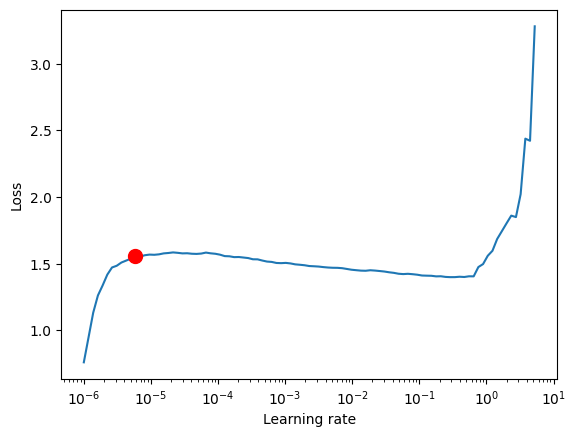

In [5]:
# ========== 8) 训练（按 CV 折） ==========
best_ckpt_paths, fold_metrics = [], []

for fold_id, (train_days, val_days) in enumerate(folds_by_day, start=1):
    print(f"[fold {fold_id}] train {train_days[0]}..{train_days[-1]} ({len(train_days)} days), "
        f"val {val_days[0]}..{val_days[-1]} ({len(val_days)} days)")
    
    # 明确日期：
    train_start_date = int(train_days[0])
    train_end_date   = int(train_days[-1])
    val_start_date   = int(val_days[0])
    val_end_date     = int(val_days[-1])      
    
    # 提取数据
    date_range = (train_start_date, val_end_date)
    pdf_data = (
        pl.scan_ipc(all_paths)
        .filter(pl.col(G_DATE).is_between(train_start_date, val_end_date, closed="both"))
        .collect(streaming=True)
        .to_pandas()
    )
    
    pdf_data[G_SYM] = pdf_data[G_SYM].astype("str")
    pdf_data.sort_values([G_SYM, "time_idx"], inplace=True)        
    # 明确 indexes:
    train_end_idx = pdf_data.loc[pdf_data[G_DATE] == train_end_date, "time_idx"].max()
    val_start_idx = pdf_data.loc[pdf_data[G_DATE] == val_start_date, "time_idx"].min()
    val_end_idx   = pdf_data.loc[pdf_data[G_DATE] == val_end_date, "time_idx"].max()
    assert pd.notna(train_end_idx) and pd.notna(val_start_idx) and pd.notna(val_end_idx), "train/val idx not found"
    train_end_idx, val_start_idx, val_end_idx = int(train_end_idx), int(val_start_idx), int(val_end_idx)
    print(f"[fold {fold_id}] train idx up to {train_end_idx}, val idx {val_start_idx}..{val_end_idx}")  
    
    pdf_data = pdf_data[TRAIN_COLS].copy()

    # 构建训练集 timeseries dataset
    identity_scalers = {name: None for name in (UNKNOWN_REALS)}
    
    base_ds = TimeSeriesDataSet(
        pdf_data,
        time_idx="time_idx",
        target=TARGET_COL,
        group_ids=[G_SYM],
        weight=WEIGHT_COL,
        max_encoder_length=ENC_LEN, 
        min_encoder_length=ENC_LEN,
        max_prediction_length=PRED_LEN, 
        min_prediction_length=PRED_LEN,
        
        static_categoricals=[G_SYM],
        
        time_varying_unknown_reals=UNKNOWN_REALS,
        
        lags=None,
        categorical_encoders={G_SYM: NaNLabelEncoder(add_nan=True)},
        add_relative_time_idx=False,
        add_target_scales=False,
        add_encoder_length=False,
        allow_missing_timesteps=True,
        target_normalizer=None,
        scalers=identity_scalers,
    )
    
    # 划分训练集，验证集
    train_ds = base_ds.filter(
        lambda idx: (
            idx.time_idx_last <= train_end_idx
        ),
        copy=True
    )
    
    val_ds = base_ds.filter(
        lambda idx: (
            (idx.time_idx_first_prediction >= val_start_idx) &
            
            (idx.time_idx_last <= val_end_idx)
        ),
        copy=True
    )
    
    # 数据集加载
    
    train_loader = train_ds.to_dataloader(
        train=True, 
        batch_size=BATCH_SIZE, 
        num_workers=8,
        pin_memory=True,
        persistent_workers=False,
        prefetch_factor=2,
    )
    
    n_train_batches = len(train_loader)
    print(f"[debug] train_loader batches = {n_train_batches}")
    assert n_train_batches > 0, "Empty train dataloader. Check min_prediction_idx/ENC_LEN/date windows."
    
    val_loader = val_ds.to_dataloader(
        train=False,
        batch_size=BATCH_SIZE,
        num_workers=8,
        pin_memory=True,
        persistent_workers=False,
        prefetch_factor=2,
    )

    n_val_batches = len(val_loader)
    print(f"[debug] val_loader batches = {n_val_batches}")
    assert n_val_batches > 0, "Empty val dataloader. Check min_prediction_idx/ENC_LEN/date windows."
    
    # calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
    baseline_predictions = Baseline().predict(val_loader, return_y=True)
    rmse = RMSE()(baseline_predictions.output, baseline_predictions.y)
    print(f"rmse: {rmse}")
    
    lp.seed_everything(42)
    trainer = lp.Trainer(
        accelerator="gpu",
        # clipping gradients is a hyperparameter and important to prevent divergance
        # of the gradient for recurrent neural networks
        gradient_clip_val=0.5,
    )

    tft = TemporalFusionTransformer.from_dataset(
        train_ds,
        # not meaningful for finding the learning rate but otherwise very important
        learning_rate=LR,
        hidden_size=HIDDEN,  # most important hyperparameter apart from learning rate
        # number of attention heads. Set to up to 4 for large datasets
        attention_head_size=HEADS,
        dropout=DROPOUT,  # between 0.1 and 0.3 are good values
        hidden_continuous_size=HIDDEN,  # set to <= hidden_size
        loss=RMSE(),
        optimizer=torch.optim.Adam,
        # reduce learning rate if no improvement in validation loss after x epochs
        # reduce_on_plateau_patience=1000,
    )
    print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")
        
    # find optimal learning rate
    from lightning.pytorch.tuner import Tuner

    res = Tuner(trainer).lr_find(
        tft,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader,
        max_lr=10.0,
        min_lr=1e-6,
    )

    print(f"suggested learning rate: {res.suggestion()}")
    fig = res.plot(show=True, suggest=True)
    fig.show()

In [ ]:
# ========== 8) 训练（按 CV 折） ==========
best_ckpt_paths, fold_metrics = [], []

for fold_id, (train_days, val_days) in enumerate(folds_by_day, start=1):
    print(f"[fold {fold_id}] train {train_days[0]}..{train_days[-1]} ({len(train_days)} days), "
        f"val {val_days[0]}..{val_days[-1]} ({len(val_days)} days)")
    
    # 明确日期：
    train_start_date = int(train_days[0])
    train_end_date   = int(train_days[-1])
    val_start_date   = int(val_days[0])
    val_end_date     = int(val_days[-1])      
    
    # 提取数据
    date_range = (train_start_date, val_end_date)
    pdf_data = (
        pl.scan_ipc(all_paths)
        .filter(pl.col(G_DATE).is_between(train_start_date, val_end_date, closed="both"))
        .collect(streaming=True)
        .to_pandas()
    )
    
    pdf_data[G_SYM] = pdf_data[G_SYM].astype("str")
    pdf_data.sort_values([G_SYM, "time_idx"], inplace=True)        
    # 明确 indexes:
    train_end_idx = pdf_data.loc[pdf_data[G_DATE] == train_end_date, "time_idx"].max()
    val_start_idx = pdf_data.loc[pdf_data[G_DATE] == val_start_date, "time_idx"].min()
    val_end_idx   = pdf_data.loc[pdf_data[G_DATE] == val_end_date, "time_idx"].max()
    assert pd.notna(train_end_idx) and pd.notna(val_start_idx) and pd.notna(val_end_idx), "train/val idx not found"
    train_end_idx, val_start_idx, val_end_idx = int(train_end_idx), int(val_start_idx), int(val_end_idx)
    print(f"[fold {fold_id}] train idx up to {train_end_idx}, val idx {val_start_idx}..{val_end_idx}")  
    
    pdf_data = pdf_data[TRAIN_COLS].copy()

    # 构建训练集 timeseries dataset
    identity_scalers = {name: None for name in (UNKNOWN_REALS)}
    
    base_ds = TimeSeriesDataSet(
        pdf_data,
        time_idx="time_idx",
        target=TARGET_COL,
        group_ids=[G_SYM],
        weight=WEIGHT_COL,
        max_encoder_length=ENC_LEN, 
        min_encoder_length=ENC_LEN,
        max_prediction_length=PRED_LEN, 
        min_prediction_length=PRED_LEN,
        
        static_categoricals=[G_SYM],
        
        time_varying_unknown_reals=UNKNOWN_REALS,
        
        lags=None,
        categorical_encoders={G_SYM: NaNLabelEncoder(add_nan=True)},
        add_relative_time_idx=False,
        add_target_scales=False,
        add_encoder_length=False,
        allow_missing_timesteps=True,
        target_normalizer=None,
        scalers=identity_scalers,
    )
    
    # 划分训练集，验证集
    train_ds = base_ds.filter(
        lambda idx: (
            idx.time_idx_last <= train_end_idx
        ),
        copy=True
    )
    
    val_ds = base_ds.filter(
        lambda idx: (
            (idx.time_idx_first_prediction >= val_start_idx) &
            
            (idx.time_idx_last <= val_end_idx)
        ),
        copy=True
    )
    
    # 数据集加载
    
    train_loader = train_ds.to_dataloader(
        train=True, 
        batch_size=BATCH_SIZE, 
        num_workers=8,
        pin_memory=True,
        persistent_workers=False,
        prefetch_factor=2,
    )
    
    n_train_batches = len(train_loader)
    print(f"[debug] train_loader batches = {n_train_batches}")
    assert n_train_batches > 0, "Empty train dataloader. Check min_prediction_idx/ENC_LEN/date windows."
    
    val_loader = val_ds.to_dataloader(
        train=False,
        batch_size=BATCH_SIZE,
        num_workers=8,
        pin_memory=True,
        persistent_workers=False,
        prefetch_factor=2,
    )

    n_val_batches = len(val_loader)
    print(f"[debug] val_loader batches = {n_val_batches}")
    assert n_val_batches > 0, "Empty val dataloader. Check min_prediction_idx/ENC_LEN/date windows."
    
    # calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
    baseline_predictions = Baseline().predict(val_loader, return_y=True)
    rmse = RMSE()(baseline_predictions.output, baseline_predictions.y)
    print(f"rmse: {rmse}")
    
    lp.seed_everything(42) 

    # 8.6 callbacks/logger/trainer
    ckpt_dir_fold = Path(CKPTS_DIR) / f"fold_{fold_id}"
    ckpt_dir_fold.mkdir(parents=True, exist_ok=True)

    callbacks = [
        EarlyStopping(
            monitor="val_loss", 
            mode="min", 
            patience=3, 
            check_on_train_epoch_end=False
        ),
        ModelCheckpoint(
            monitor="val_loss",
            mode="min",
            save_top_k=1,
            dirpath=ckpt_dir_fold.as_posix(),
            filename=f"fold{fold_id}-tft-best-{{epoch:02d}}-{{val_loss:.5f}}",
            save_on_train_epoch_end=False
        )
        
    ]
    RUN_NAME = (
        f"f{fold_id}"
        f"_E{MAX_EPOCHS}"
        f"_lr{LR}"
        f"_bs{BATCH_SIZE}"
        f"_enc{ENC_LEN}_dec{DEC_LEN}"
        f"_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    )
    logger = TensorBoardLogger(
        save_dir=LOGS_DIR.as_posix(),
        name="tft",
        version=RUN_NAME,
        default_hp_metric=False
    )

    trainer = lp.Trainer(
        max_epochs=5,
        accelerator="gpu",
        enable_model_summary=True,
        gradient_clip_val=0.1,
        limit_train_batches=50,  # coment in for training, running valiation every 30 batches
        callbacks=callbacks,
        logger=logger,
    )

    tft = TemporalFusionTransformer.from_dataset(
        train_ds,
        learning_rate=0.01,
        hidden_size=16,
        attention_head_size=HEADS,
        dropout=DROPOUT,
        hidden_continuous_size=HIDDEN,
        loss=RMSE(),
        log_interval=30,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
        optimizer=torch.optim.Adam,
        reduce_on_plateau_patience=4,
    )
    print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")
    
    trainer.fit(
        tft,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader,
        )
    
    ckpt_cb = next(cb for cb in callbacks if isinstance(cb, ModelCheckpoint))
    best_path = ckpt_cb.best_model_path
    best_tft = TemporalFusionTransformer.load_from_checkpoint(best_path)

    predictions = best_tft.predict(
        val_loader,
        return_y=True,
        trainer_kwargs=dict(accelerator="cpu")
    )
    rmse = RMSE()(predictions.output, predictions.y,)
    print(f"rmse after training: {rmse}")

[fold 1] train 1610..1634 (25 days), val 1642..1647 (6 days)
[fold 1] train idx up to 24199, val idx 30976..36783


/home/admin_ml/Jackson/projects/js/JS/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/admin_ml/Jackson/projects/js/JS/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[debug] train_loader batches = 1825
[debug] val_loader batches = 443


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 520    | train
3  | prescalers                         | ModuleDict                      | 832    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 48     | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 38.2 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7

rmse: 0.4517226815223694
Number of parameters in network: 52.9k
Epoch 3: 100%|██████████| 50/50 [00:22<00:00,  2.20it/s, v_num=3131, train_loss_step=1.410, val_loss=0.912, train_loss_epoch=1.340]


/home/admin_ml/Jackson/projects/js/JS/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/admin_ml/Jackson/projects/js/JS/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/admin_ml/Jackson/projects/js/JS/.venv/lib/python3.10/site-packages

SystemExit: 1

/home/admin_ml/Jackson/projects/js/JS/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
